# Goal
This notebook contains script that loads the SNP embeddings and train an autoencoder

In [3]:
import numpy as np
import pandas as pd
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from tqdm.notebook import tqdm
import scipy.sparse as sp

## Prepare the data

### Load and Convert the embedding to DataFrame

In [4]:
import os
import pandas as pd
import numpy as np

# Directories for input and output
output_dir = '../../Data/SSC_VEP_filtered'
image_output_dir = '../../Image'
os.makedirs(image_output_dir, exist_ok=True)

# Path to the directory with TF embedding files
embedding_files_dir = '../../Data/TF_Embeddings_Multiclass/'

# Load all the embedding CSV files from the directory
embedding_files = [os.path.join(embedding_files_dir, file) for file in os.listdir(embedding_files_dir) if file.endswith('.csv')]

# Initialize an empty list to store DataFrames
embedding_dfs = []

# Load and append each embedding DataFrame to the list
for file in embedding_files:
    df = pd.read_csv(file, index_col=0)  # Read each CSV file
    embedding_dfs.append(df)

# Merge all the DataFrames into one by concatenating along the row axis (index)
embedding_matrix = pd.concat(embedding_dfs, axis=0)

print(f'Embedding matrix shape after merging: {embedding_matrix.shape}')
print(f'Embedding matrix type: {type(embedding_matrix)}')

# Remove columns with all zero values
embedding_matrix = embedding_matrix.loc[:, embedding_matrix.sum() > 0]
print(f'Embedding matrix shape after removing zeros: {embedding_matrix.shape}')

# Remove enhancer columns (columns that don't contain 'ENS')
TF_Cols = [True if 'ENS' in col else False for col in embedding_matrix.columns]
embedding_matrix = embedding_matrix.loc[:, TF_Cols]
print(f'Embedding matrix shape after removing zeros and enhancers: {embedding_matrix.shape}')

# Ensure the data type is int
embedding_matrix = embedding_matrix.astype(int)

# Check for any issues in the embedding matrix
if np.any(np.isnan(embedding_matrix)):
    raise ValueError("Embedding matrix contains NaN values")

# Optionally, save the merged and processed embedding matrix
merged_output_path = os.path.join(output_dir, 'merged_tf_embeddings.csv')
embedding_matrix.to_csv(merged_output_path)
print(f'Merged embedding matrix saved to {merged_output_path}')


Embedding matrix shape after merging: (2586, 50599)
Embedding matrix type: <class 'pandas.core.frame.DataFrame'>
Embedding matrix shape after removing zeros: (2586, 38788)
Embedding matrix shape after removing zeros and enhancers: (2586, 5803)
Merged embedding matrix saved to ../../Data/SSC_VEP_filtered/merged_tf_embeddings.csv


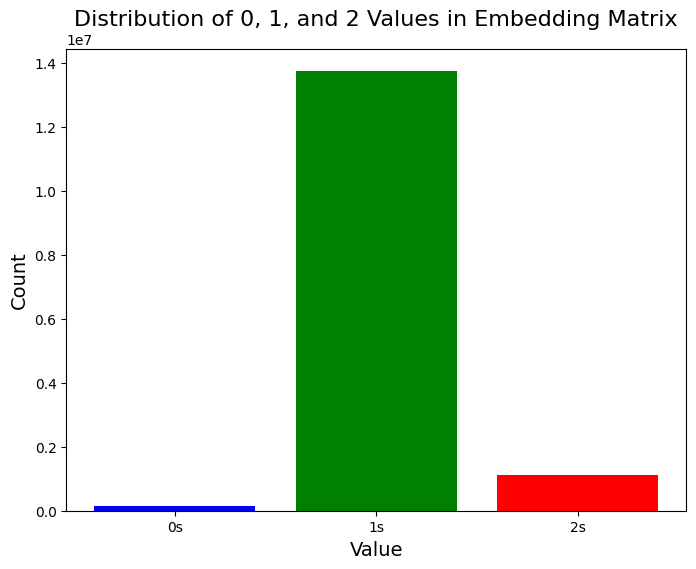

In [5]:
import matplotlib.pyplot as plt

# Count occurrences of 0, 1, and 2 in the entire embedding matrix
zero_total = (embedding_matrix == 0).sum().sum()
one_total = (embedding_matrix == 1).sum().sum()
two_total = (embedding_matrix == 2).sum().sum()

# Data for the histogram
values = ['0s', '1s', '2s']
counts = [zero_total, one_total, two_total]

# Create a bar plot (histogram)
plt.figure(figsize=(8, 6))
plt.bar(values, counts, color=['blue', 'green', 'red'])

# Add labels and title
plt.title('Distribution of 0, 1, and 2 Values in Embedding Matrix', fontsize=16)
plt.xlabel('Value', fontsize=14)
plt.ylabel('Count', fontsize=14)

# Show the histogram
plt.show()


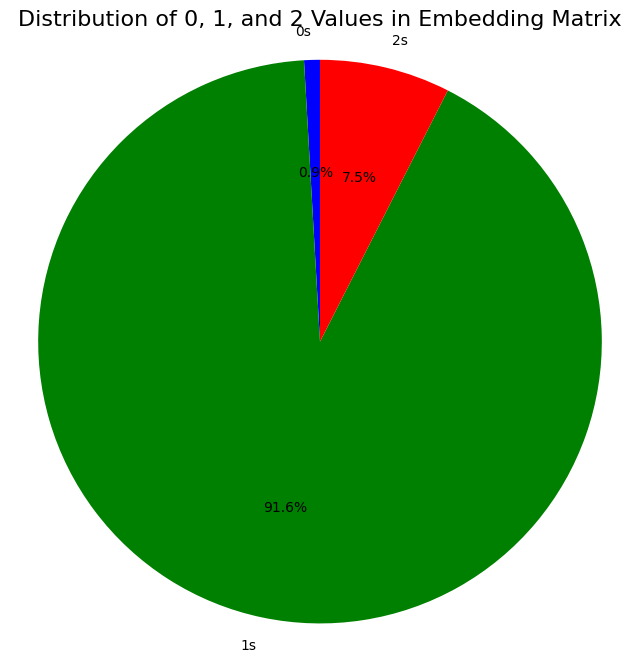

In [6]:
import matplotlib.pyplot as plt

# Count occurrences of 0, 1, and 2 in the entire embedding matrix
zero_total = (embedding_matrix == 0).sum().sum()
one_total = (embedding_matrix == 1).sum().sum()
two_total = (embedding_matrix == 2).sum().sum()

# Data for the pie chart
labels = ['0s', '1s', '2s']
sizes = [zero_total, one_total, two_total]
colors = ['blue', 'green', 'red']

# Create a pie chart without shadow
plt.figure(figsize=(8, 8))
plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=90)

# Equal aspect ratio ensures that the pie chart is drawn as a circle.
plt.axis('equal')

# Add a title
plt.title('Distribution of 0, 1, and 2 Values in Embedding Matrix', fontsize=16)

# Show the pie chart
plt.show()


## Train the autoencoder

### Define the model

In [7]:
import torch
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import numpy as np

class LargeDataset(Dataset):
    def __init__(self, data):
        self.data = data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        batch = self.data.iloc[idx]
        batch_tensor = torch.tensor(batch.values, dtype=torch.float32)
        return batch_tensor, batch_tensor  # Returning the same tensor as input and target


# Create a dataset and dataloader
dataset = LargeDataset(embedding_matrix)
batch_size = 32
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)


Train the Autoencoder in Batches

In [8]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from tqdm.notebook import tqdm
import torch.nn.functional as F

class Autoencoder(nn.Module):
    def __init__(self, input_dim, hidden_dim1, hidden_dim2, code_dim):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, hidden_dim1),
            nn.ReLU(),
            nn.Linear(hidden_dim1, hidden_dim2),
            nn.ReLU(),
            nn.Linear(hidden_dim2, code_dim),
            nn.ReLU()
        )
        self.decoder = nn.Sequential(
            nn.Linear(code_dim, hidden_dim2),
            nn.ReLU(),
            nn.Linear(hidden_dim2, hidden_dim1),
            nn.ReLU(),
            nn.Linear(hidden_dim1, input_dim),
            nn.ReLU() 
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return encoded, decoded


In [9]:
# Set parameters
input_dim = embedding_matrix.shape[1]
hidden_dim1 = 1024
hidden_dim2 = 512
code_dim = 128  # Adjusted reduced dimension

# Initialize autoencoder
device = torch.device('mps' if torch.backends.mps.is_available() else 'cuda' if torch.cuda.is_available() else 'cpu')
autoencoder = Autoencoder(input_dim, hidden_dim1, hidden_dim2, code_dim).to(device)

# Training settings
criterion = nn.MSELoss()
optimizer = optim.Adam(autoencoder.parameters(), lr=0.001)
num_epochs = 50
batch_size = 32

# Custom dataset and dataloader
class LargeDataset(Dataset):
    def __init__(self, data):
        self.data = data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        batch = self.data.iloc[idx]
        batch_tensor = torch.tensor(batch.values, dtype=torch.float32)
        return batch_tensor, batch_tensor  # Returning the same tensor as input and target

dataset = LargeDataset(embedding_matrix)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# Training loop with overall progress bar
progress_bar = tqdm(total=num_epochs, desc='Training Autoencoder', unit='epoch')

for epoch in range(num_epochs):
    epoch_loss = 0
    for batch_features, _ in dataloader:
        batch_features = batch_features.to(device)

        optimizer.zero_grad()
        encoded, decoded = autoencoder(batch_features)
        loss = criterion(decoded, batch_features)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    
    progress_bar.set_postfix({'loss': epoch_loss / len(dataloader)})
    progress_bar.update(1)
progress_bar.close()

# Extract the encoded features and calculate reconstruction error
autoencoder.eval()
encoded_embeddings = []
reconstruction_errors = []

with torch.no_grad():
    for batch_features, _ in dataloader:
        batch_features = batch_features.to(device)
        encoded, decoded = autoencoder(batch_features)
        encoded_embeddings.append(encoded.cpu().numpy())
        
        # Calculate reconstruction error for the batch
        batch_mse = F.mse_loss(decoded, batch_features, reduction='none').mean(dim=1)
        reconstruction_errors.append(batch_mse.cpu().numpy())

encoded_embeddings = np.vstack(encoded_embeddings)
reconstruction_errors = np.concatenate(reconstruction_errors)

# Calculate overall reconstruction accuracy
average_reconstruction_error = reconstruction_errors.mean()
print(f'Average Reconstruction Error (MSE): {average_reconstruction_error}')

# Print the shape of the encoded embeddings
print(f'Encoded embeddings shape: {encoded_embeddings.shape}')


Training Autoencoder:   0%|          | 0/50 [00:00<?, ?epoch/s]

Average Reconstruction Error (MSE): 0.16548877954483032
Encoded embeddings shape: (2586, 128)


In [10]:
# Save the trained autoencoder model
autoencoder_path = 'autoencoder.pth'
torch.save(autoencoder.state_dict(), autoencoder_path)
print(f'Autoencoder model saved to {autoencoder_path}')


Autoencoder model saved to autoencoder.pth


In [11]:
import numpy as np

# Assuming encoded_embeddings is already computed
# Save the encoded embeddings to a file
encoded_embeddings_path = 'encoded_embeddings.npy'
np.save(encoded_embeddings_path, encoded_embeddings)
print(f'Encoded embeddings saved to {encoded_embeddings_path}')


Encoded embeddings saved to encoded_embeddings.npy


In [12]:
import pandas as pd

# Convert encoded embeddings to a DataFrame
encoded_embeddings_df = pd.DataFrame(encoded_embeddings, index=embedding_matrix.index)

# Save the DataFrame to a CSV file
encoded_embeddings_df.to_csv('encoded_embeddings.csv')
print('Encoded embeddings saved to encoded_embeddings.csv')


Encoded embeddings saved to encoded_embeddings.csv


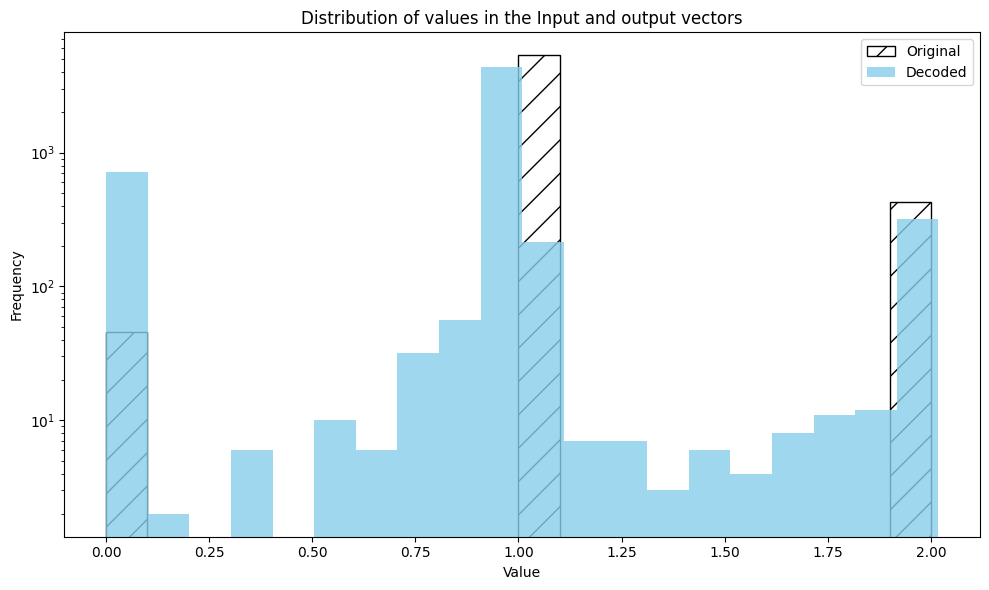

In [13]:
import matplotlib.pyplot as plt
i = 0

def plot_dist(i):
    foo = decoded[i].cpu()
    bar = batch_features[i].cpu()
    
    # Convert tensors to numpy arrays for plotting
    foo_np = foo.numpy()
    bar_np = bar.numpy()
    
    # Plot the histograms with different styles
    plt.figure(figsize=(10, 6))
    
    plt.hist(bar_np, bins=20, color='white', edgecolor='black', label='Original', hatch='/')
    plt.hist(foo_np, bins=20, color='skyblue', alpha=0.8, label='Decoded', hatch='')
    
    plt.title('Distribution of values in the Input and output vectors')
    plt.xlabel('Value')
    plt.ylabel('Frequency')
    plt.yscale('log')
    plt.legend()
    plt.tight_layout()
    plt.savefig(os.path.join(image_output_dir, 'Distribution of values in the Input and output vectors.jpg'))
    plt.show()

plot_dist(i)


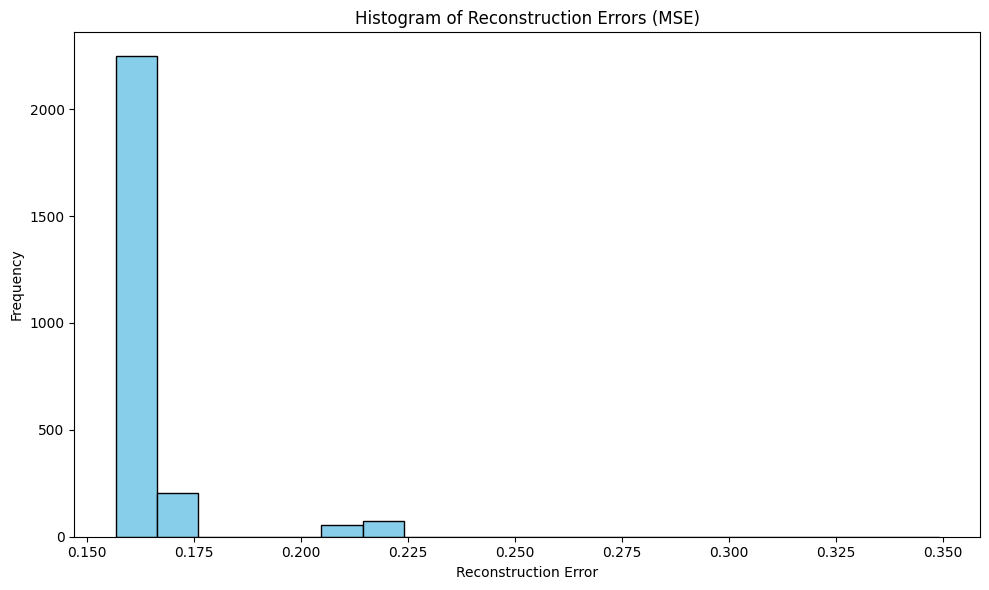

In [14]:
import matplotlib.pyplot as plt

# Plot the histogram of reconstruction errors
plt.figure(figsize=(10, 6))
plt.hist(reconstruction_errors, bins=20, color='skyblue', edgecolor='black')
plt.title('Histogram of Reconstruction Errors (MSE)')
plt.xlabel('Reconstruction Error')
plt.ylabel('Frequency')
plt.tight_layout()
plt.savefig(os.path.join(image_output_dir, 'reconstruction_error_histogram.png'))
plt.show()


In [15]:
encoded_embeddings_df = pd.read_csv('encoded_embeddings.csv', index_col=0)

In [16]:
id_map = pd.read_csv("../../Data/SSC_VEP_GZ/documentation/nygc_sfari_id_map.csv")
id_map['Role'] = id_map['SFARI ID'].apply(lambda x: x.split(".")[1])

In [17]:
id_map

,SFARI ID,Repository Id,Role
0,11000.fa,SSC02219,fa
1,11000.mo,SSC02217,mo
2,11000.p1,SSC02254,p1
3,11000.s1,SSC02220,s1
4,11001.fa,SSC02184,fa
...,...,...,...
9380,14698.s1,SSC12833,s1
9381,14699.fa,SSC12952,fa
9382,14699.mo,SSC12951,mo
9383,14699.p1,SSC12957,p1


In [18]:
encoded_embeddings_df.index = [x.replace('.bed',"") for x in encoded_embeddings_df.index]

In [19]:
# Merge the DataFrames based on the 'Repository Id' column
merged_df = pd.merge(id_map, encoded_embeddings_df, left_on='Repository Id', right_index=True)
merged_df['ASD'] = merged_df['Role'].apply(lambda x: 1 if x == 'p1' else 0)
merged_df

,SFARI ID,Repository Id,Role,0,1,2,3,4,5,6,...,119,120,121,122,123,124,125,126,127,ASD
4,11001.fa,SSC02184,fa,2.648492,1.790441,0.0,0.0,0.261187,4.074441,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
5,11001.mo,SSC02181,mo,2.663702,1.800313,0.0,0.0,0.263255,4.098347,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
6,11001.p1,SS0013024,p1,2.658673,1.796858,0.0,0.0,0.262359,4.090343,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
19,11006.fa,SSC00004,fa,2.642474,1.785303,0.0,0.0,0.260385,4.063332,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
20,11006.mo,SSC00005,mo,2.657654,1.796833,0.0,0.0,0.262299,4.089459,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9349,14690.p1,SSC09667,p1,2.652504,1.792931,0.0,0.0,0.260277,4.078258,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
9358,14693.fa,SSC12649,fa,2.661211,1.799569,0.0,0.0,0.263321,4.095641,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
9359,14693.mo,SSC12644,mo,2.650106,1.790737,0.0,0.0,0.260471,4.075317,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
9359,14693.mo,SSC12644,mo,2.644217,1.786853,0.0,0.0,0.259711,4.066114,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0


In [20]:
import numpy as np

# Assume merged_df is already defined and contains the required data

# Define columns to exclude (identifiers and labels)
exclude_columns = ['SFARI ID', 'Repository Id', 'Fam', 'Role', 'ASD']

# Extract feature columns by excluding the specified columns
feature_columns = [col for col in merged_df.columns if col not in exclude_columns]

# Extract X and y from merged_df
X = merged_df[feature_columns].values
y = merged_df['ASD'].values

print(f'Feature matrix shape: {X.shape}')
print(f'Labels shape: {y.shape}')


Feature matrix shape: (2586, 128)
Labels shape: (2586,)


### test tain split

In [21]:
from sklearn.model_selection import train_test_split

# Split the encoded features and labels into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(f'X_train shape: {X_train.shape}, X_test shape: {X_test.shape}')


X_train shape: (2068, 128), X_test shape: (518, 128)


### compute class weights

In [22]:
from sklearn.utils.class_weight import compute_class_weight

# Compute class weights to handle class imbalance
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weight_dict = dict(zip(np.unique(y_train), class_weights))
print(f'Class weights: {class_weight_dict}')


Class weights: {0: 0.7180555555555556, 1: 1.6464968152866242}


### train

In [23]:
from sklearn.linear_model import LogisticRegression

# Train a Logistic Regression classifier with class weights
classifier = LogisticRegression(max_iter=500, random_state=42, class_weight=class_weight_dict)
classifier.fit(X_train, y_train)


LogisticRegression(class_weight={0: 0.7180555555555556, 1: 1.6464968152866242},
                   max_iter=500, random_state=42)

### evaluate

In [24]:
X_test

array([[2.641607 , 1.7861515, 0.       , ..., 0.       , 0.       ,
        0.       ],
       [2.6508205, 1.7912976, 0.       , ..., 0.       , 0.       ,
        0.       ],
       [2.66054  , 1.7981601, 0.       , ..., 0.       , 0.       ,
        0.       ],
       ...,
       [2.6587067, 1.7975191, 0.       , ..., 0.       , 0.       ,
        0.       ],
       [2.653251 , 1.7942318, 0.       , ..., 0.       , 0.       ,
        0.       ],
       [2.6622808, 1.7996671, 0.       , ..., 0.       , 0.       ,
        0.       ]])

In [25]:
from sklearn.metrics import accuracy_score, classification_report

# Predict on the test set
y_pred = classifier.predict(X_test)

# Evaluate the classifier
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred, target_names=['Negative', 'Positive'], zero_division=1)

print(f'Accuracy: {accuracy}')
print('Classification Report:')
print(report)

Accuracy: 0.584942084942085
Classification Report:
              precision    recall  f1-score   support

    Negative       0.72      0.66      0.69       364
    Positive       0.33      0.40      0.36       154

    accuracy                           0.58       518
   macro avg       0.53      0.53      0.53       518
weighted avg       0.61      0.58      0.59       518



In [26]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, accuracy_score

# Initialize the Decision Tree classifier with class weights
classifier = DecisionTreeClassifier(random_state=42, class_weight='balanced')

# Fit the Decision Tree model to the training data
classifier.fit(X_train, y_train)

# Make predictions on the test data
y_pred = classifier.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy}')

# Classification report provides precision, recall, and F1-score
print(classification_report(y_test, y_pred, target_names=['Class 0', 'Class 1']))


Accuracy: 0.5752895752895753
              precision    recall  f1-score   support

     Class 0       0.70      0.70      0.70       364
     Class 1       0.28      0.28      0.28       154

    accuracy                           0.58       518
   macro avg       0.49      0.49      0.49       518
weighted avg       0.57      0.58      0.57       518



### Neural Network

## Random Forest

In [47]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Initialize the Random Forest classifier with class weights
classifier = RandomForestClassifier(random_state=42, class_weight='balanced')

# Fit the model to the training data
classifier.fit(X_train, y_train)


RandomForestClassifier(class_weight='balanced', random_state=42)

In [48]:
# Make predictions on the test data
y_pred = classifier.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy}')

# Classification report provides precision, recall, and F1-score
print(classification_report(y_test, y_pred, target_names=['Class 0', 'Class 1']))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
print('Confusion Matrix:\n', cm)


Accuracy: 0.6814671814671814
              precision    recall  f1-score   support

     Class 0       0.70      0.96      0.81       364
     Class 1       0.21      0.03      0.05       154

    accuracy                           0.68       518
   macro avg       0.45      0.49      0.43       518
weighted avg       0.55      0.68      0.58       518

Confusion Matrix:
 [[349  15]
 [150   4]]


In [35]:
# Calculate the proportion of the positive and negative classes
n_positive = (y_train == 1).sum()
n_negative = (y_train == 0).sum()

# Class weights for balancing (use inverse of the frequency)
pos_weight = torch.tensor([n_negative / n_positive], dtype=torch.float32)


In [27]:
import torch
from torch.utils.data import Dataset

class CustomDataset(Dataset):
    def __init__(self, X, y):
        self.X = X  # Keep X and y in their original form (e.g., NumPy arrays or pandas DataFrames)
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        # Convert to tensor only when accessed
        X_tensor = torch.tensor(self.X[idx], dtype=torch.float32)
        y_tensor = torch.tensor(self.y[idx], dtype=torch.long)
        return X_tensor, y_tensor


In [28]:
# Create Dataset and DataLoader for batch processing
train_dataset = CustomDataset(X_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

# Test Dataset and DataLoader
test_dataset = CustomDataset(X_test, y_test)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)


In [38]:
import torch.nn as nn
import torch.optim as optim

class NeuralNet(nn.Module):
    def __init__(self, input_dim, hidden_dim1, hidden_dim2, output_dim=1):
        super(NeuralNet, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim1)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(hidden_dim1, hidden_dim2)
        self.relu2 = nn.ReLU()
        self.fc3 = nn.Linear(hidden_dim2, output_dim)

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu1(x)
        x = self.fc2(x)
        x = self.relu2(x)
        x = self.fc3(x)
        return x  # No Sigmoid, since we'll use BCEWithLogitsLoss


# Initialize the model
input_dim = X_train.shape[1]  # Number of features
hidden_dim1 = 128
hidden_dim2 = 64
model = NeuralNet(input_dim, hidden_dim1, hidden_dim2)


In [40]:
# Loss function and optimizer with class weights
criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)  # Adding class weight for imbalance
optimizer = optim.Adam(model.parameters(), lr=0.001)



In [43]:
# Training the model
def train_model(model, train_loader, criterion, optimizer, num_epochs=10):
    model.train()
    for epoch in range(num_epochs):
        running_loss = 0.0
        for inputs, labels in train_loader:
            # Forward pass
            outputs = model(inputs).squeeze()  # Make sure outputs and labels have the same shape
            loss = criterion(outputs, labels.float())  # Labels should be float for BCELoss

            # Backward pass and optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}")

# Train the model for 10 epochs
train_model(model, train_loader, criterion, optimizer, num_epochs=50)


Epoch [1/50], Loss: 0.9666
Epoch [2/50], Loss: 0.9667
Epoch [3/50], Loss: 0.9693
Epoch [4/50], Loss: 0.9649
Epoch [5/50], Loss: 0.9655
Epoch [6/50], Loss: 0.9654
Epoch [7/50], Loss: 0.9645
Epoch [8/50], Loss: 0.9634
Epoch [9/50], Loss: 0.9654
Epoch [10/50], Loss: 0.9666
Epoch [11/50], Loss: 0.9645
Epoch [12/50], Loss: 0.9627
Epoch [13/50], Loss: 0.9682
Epoch [14/50], Loss: 0.9646
Epoch [15/50], Loss: 0.9685
Epoch [16/50], Loss: 0.9620
Epoch [17/50], Loss: 0.9655
Epoch [18/50], Loss: 0.9625
Epoch [19/50], Loss: 0.9645
Epoch [20/50], Loss: 0.9644
Epoch [21/50], Loss: 0.9675
Epoch [22/50], Loss: 0.9636
Epoch [23/50], Loss: 0.9625
Epoch [24/50], Loss: 0.9665
Epoch [25/50], Loss: 0.9635
Epoch [26/50], Loss: 0.9654
Epoch [27/50], Loss: 0.9653
Epoch [28/50], Loss: 0.9663
Epoch [29/50], Loss: 0.9634
Epoch [30/50], Loss: 0.9662
Epoch [31/50], Loss: 0.9682
Epoch [32/50], Loss: 0.9654
Epoch [33/50], Loss: 0.9664
Epoch [34/50], Loss: 0.9635
Epoch [35/50], Loss: 0.9672
Epoch [36/50], Loss: 0.9662
E

In [44]:
# Evaluation function
def evaluate_model(model, test_loader):
    model.eval()  # Set to evaluation mode
    y_true = []
    y_pred = []
    with torch.no_grad():
        for inputs, labels in test_loader:
            outputs = model(inputs).squeeze()
            predicted = (outputs >= 0.5).int()  # Convert probabilities to binary 0 or 1
            y_true.extend(labels.tolist())
            y_pred.extend(predicted.tolist())

    return y_true, y_pred

# Evaluate the model
y_true, y_pred = evaluate_model(model, test_loader)

# Calculate accuracy, precision, recall, and F1 score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

print(f'Accuracy: {accuracy_score(y_true, y_pred)}')
print(f'Precision: {precision_score(y_true, y_pred)}')
print(f'Recall: {recall_score(y_true, y_pred)}')
print(f'F1 Score: {f1_score(y_true, y_pred)}')


Accuracy: 0.7027027027027027
Precision: 0.0
Recall: 0.0
F1 Score: 0.0


/opt/anaconda3/envs/GRN/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


# TF + Enhancer

In [2]:
import os
import numpy as np
import pandas as pd

# Directories for input and output
output_dir = '../../Data/SSC_VEP_filtered'

# Load the TF embeddings
tf_embedding_matrix = pd.read_csv('../../Data/TF_Embeddings/tf_embeddings_batch_10.csv', index_col=0)

# Process TF Embeddings (already done in your existing code)
TF_Cols = [True if 'ENS' in col else False for col in tf_embedding_matrix.columns]
tf_embedding_matrix = tf_embedding_matrix.loc[:, TF_Cols]
tf_embedding_matrix = tf_embedding_matrix.astype(int)

# Load the Enhancer embeddings
enhancer_embedding_matrix = pd.read_csv('../../Data/Enhancer_Embeddings/enhancer_embeddings_batch_10.csv', index_col=0)

# Process Enhancer Embeddings (remove non-enhancer columns, i.e., those not starting with 'E')
enhancer_embedding_matrix = enhancer_embedding_matrix.loc[:, [col for col in enhancer_embedding_matrix.columns if col.startswith('E')]]
enhancer_embedding_matrix = enhancer_embedding_matrix.astype(int)

# Merge the two matrices with an OR gate (element-wise maximum)
merged_embeddings = np.maximum(tf_embedding_matrix.values, enhancer_embedding_matrix.values)


# Convert back to DataFrame for easier manipulation and saving
merged_embeddings_df = pd.DataFrame(merged_embeddings, index=tf_embedding_matrix.index, columns=tf_embedding_matrix.columns)

merged_embeddings_df = merged_embeddings_df.loc[:, merged_embeddings_df.sum() > 0]

# Save the merged embeddings
output_merged_file = os.path.join(output_dir, 'merged_tf_enhancer_embeddings.csv')
merged_embeddings_df.to_csv(output_merged_file)

print(f'Merged embeddings shape: {merged_embeddings_df.shape}')
print(f'Merged embeddings saved to: {output_merged_file}')


Merged embeddings shape: (1280, 5803)
Merged embeddings saved to: ../../Data/SSC_VEP_filtered/merged_tf_enhancer_embeddings.csv


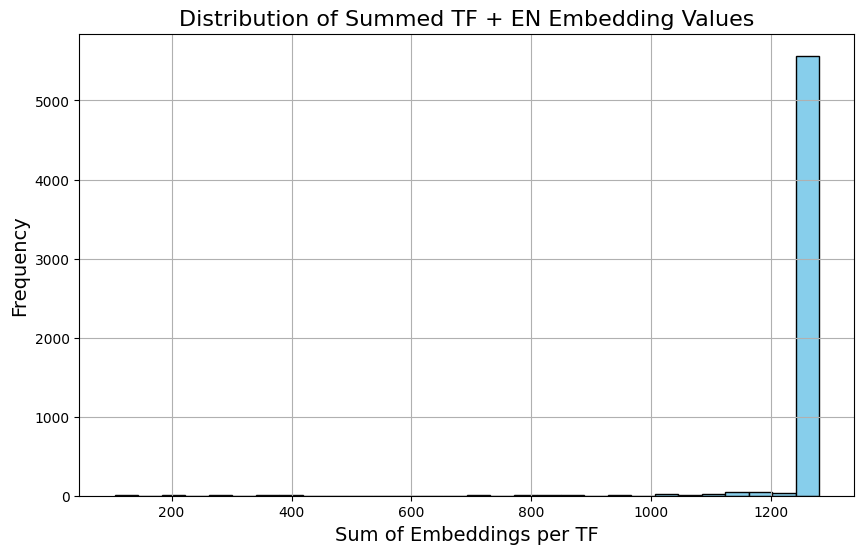

In [19]:
import matplotlib.pyplot as plt

# Plot the histogram of the sum of the embeddings
plt.figure(figsize=(10, 6))  # Set the figure size
plt.hist(merged_embeddings_df.sum(), bins=30, color='skyblue', edgecolor='black')  # Adjust the number of bins and color

# Add a title and axis labels
plt.title('Distribution of Summed TF + EN Embedding Values', fontsize=16)
plt.xlabel('Sum of Embeddings per TF', fontsize=14)
plt.ylabel('Frequency', fontsize=14)

# Add a grid for better readability
plt.grid(True)

plt.savefig("../../Image/TF_EN_emb_col_sum_hist.png")
# Show the plot
plt.show()


In [20]:
tf_embeddings_df = pd.DataFrame(tf_embedding_matrix)

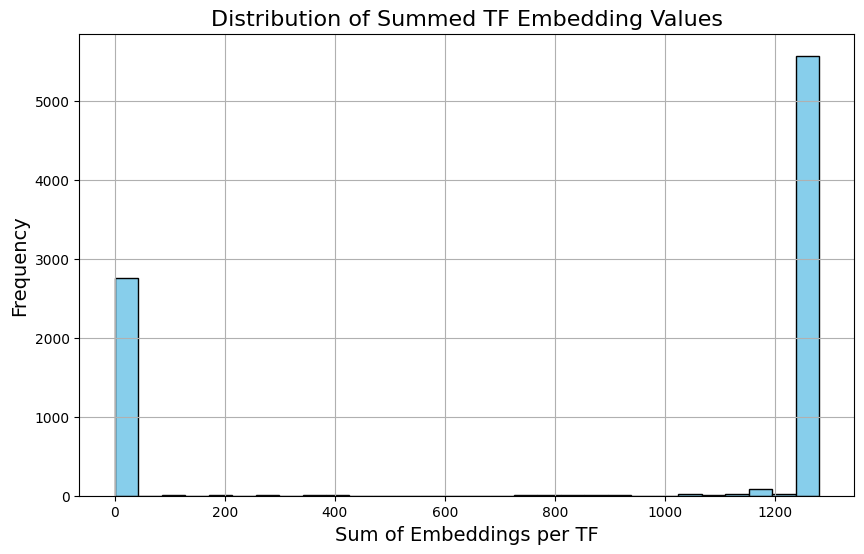

In [23]:
import matplotlib.pyplot as plt

# Plot the histogram of the sum of the embeddings
plt.figure(figsize=(10, 6))  # Set the figure size
plt.hist(tf_embeddings_df.sum(), bins=30, color='skyblue', edgecolor='black')  # Adjust the number of bins and color

# Add a title and axis labels
plt.title('Distribution of Summed TF Embedding Values', fontsize=16)
plt.xlabel('Sum of Embeddings per TF', fontsize=14)
plt.ylabel('Frequency', fontsize=14)

# Add a grid for better readability
plt.grid(True)

plt.savefig("../../Image/TF_emb_col_sum_hist.png")
# Show the plot
plt.show()


In [24]:
merged_embeddings_df

,ENSG00000228794.10,ENSG00000223764.2,ENSG00000187634.12,ENSG00000188976.11,ENSG00000187961.14,ENSG00000188157.15,ENSG00000131591.17,ENSG00000078808.17,ENSG00000184163.3,ENSG00000260179.1,...,ENSG00000169057.23,ENSG00000007350.17,ENSG00000196924.18,ENSG00000285018.1,ENSG00000013563.14,ENSG00000102125.16,ENSG00000126903.16,ENSG00000071889.16,ENSG00000160211.19,ENSG00000269335.5
SSC08026.bed,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
SSC07315.bed,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
SSC08740.bed,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
SSC08754.bed,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
SSC07467.bed,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
SSC09149.bed,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
SSC07164.bed,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
SSC07602.bed,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
SSC05001.bed,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
